In [151]:
# import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from math import log
import sys
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)

In [135]:
# info
stock = 'AAPL'
start_date = '2016-01-01'
end_date = '2022-01-01'
time_interval = '1d'

# sequence variables
# how many intervals the sequences will be
input_length = 10
# how many predictions will be made
output_length = 1

In [136]:
# import data
init_df = yf.download(stock, start=start_date, end=end_date, interval=time_interval)

[*********************100%***********************]  1 of 1 completed


In [137]:
# preprocess data
df = init_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df['Date'] = df.index
df['Simple_return'] = (df['Close'] - df['Close'].shift(+1)) / df['Close'].shift(+1)
df['Log_prices'] = np.log(df['Close'])
df['Log_returns'] = df['Log_prices'].diff()
df = df.dropna()

<Axes: xlabel='Date'>

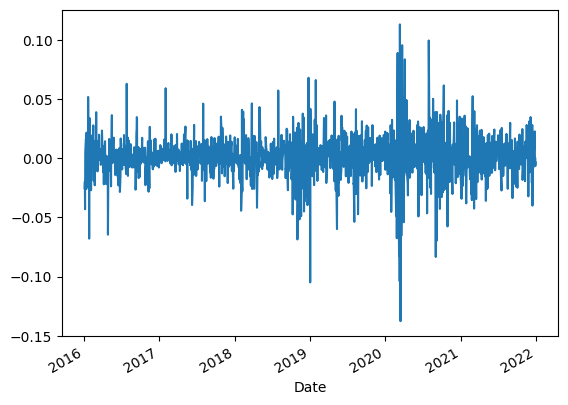

In [138]:
# plot returns
df['Log_returns'].plot()

In [139]:
# check for stationarity
adfuller(df['Log_returns'])

(-11.90798914949214,
 5.379415956670009e-22,
 8,
 1501,
 {'1%': -3.4347141029098758,
  '5%': -2.8634674740559594,
  '10%': -2.5677961635037003},
 -7698.488624638345)

In [140]:
# create train and test data
split_index = int(len(df) * 0.9)
train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]

# extract the target variable (Log_returns)
X_train_raw = train_df['Log_returns'].values.reshape(-1, 1)
y_train_raw = train_df['Log_returns'].values.reshape(-1, 1)
X_test_raw = test_df['Log_returns'].values.reshape(-1, 1)
y_test_raw = test_df['Log_returns'].values.reshape(-1, 1)

# scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)

X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

In [141]:
# create sequences
def create_sequences(data, input_length, output_length):
    X = []
    y = []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_scaled, input_length, output_length)
X_test, y_test = create_sequences(X_test_scaled, input_length, output_length)

In [142]:
# build the model
model = keras.models.Sequential([
    keras.layers.Input(shape=(input_length, 1)),
    keras.layers.LSTM(50,return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(100, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(20),
    keras.layers.Dense((output_length), kernel_regularizer=keras.regularizers.l2(0.0001))
])

In [72]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,841 (284.54 KB)

 Trainable params: 72,841 (284.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [143]:
# compile the model
loss = keras.losses.MeanSquaredError()
optim = keras.optimizers.Adam()
metrics = ['mean_squared_error']

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [144]:
# train the model
batch_size = 8
epochs = 100

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/100
169/169 - 6s - 34ms/step - loss: 1.0120 - mean_squared_error: 1.0060
Epoch 2/100
169/169 - 4s - 22ms/step - loss: 1.0031 - mean_squared_error: 0.9995
Epoch 3/100
169/169 - 4s - 23ms/step - loss: 1.0018 - mean_squared_error: 0.9986
Epoch 4/100
169/169 - 2s - 10ms/step - loss: 0.9975 - mean_squared_error: 0.9947
Epoch 5/100
169/169 - 3s - 15ms/step - loss: 0.9910 - mean_squared_error: 0.9881
Epoch 6/100
169/169 - 3s - 17ms/step - loss: 0.9951 - mean_squared_error: 0.9921
Epoch 7/100
169/169 - 3s - 17ms/step - loss: 0.9872 - mean_squared_error: 0.9840
Epoch 8/100
169/169 - 4s - 23ms/step - loss: 0.9889 - mean_squared_error: 0.9853
Epoch 9/100
169/169 - 2s - 11ms/step - loss: 0.9751 - mean_squared_error: 0.9712
Epoch 10/100
169/169 - 2s - 11ms/step - loss: 0.9791 - mean_squared_error: 0.9746
Epoch 11/100
169/169 - 3s - 15ms/step - loss: 0.9680 - mean_squared_error: 0.9636
Epoch 12/100
169/169 - 3s - 16ms/step - loss: 0.9731 - mean_squared_error: 0.9677
Epoch 13/100
169/169 - 2s

In [145]:
# evaluate the model
model.evaluate(X_test, y_test, verbose=2)

5/5 - 0s - 94ms/step - loss: 0.6486 - mean_squared_error: 0.6295


[0.6486176252365112, 0.6295202970504761]

In [146]:
# make predictions
predictions = model.predict(X_test)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
predicted = scaler_y.inverse_transform(predictions.reshape(-1, 1))

pd.DataFrame({
    'Actual': actual.flatten(),
    'Predicted': predicted.flatten()
})

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


,Actual,Predicted
0,0.024281,0.000423
1,-0.006459,0.000736
2,0.003926,-0.001423
3,0.012522,0.000369
4,-0.010143,0.001461
5,0.014005,0.000037
6,0.012618,0.000936
7,-0.002092,0.000646
8,-0.002171,-0.000025
9,-0.002251,0.000638


In [147]:
analysis = pd.DataFrame({
    'Actual_log_r': actual.flatten(),
    'Predicted_log_r': predicted.flatten(),
    'Actual_simple_r': np.exp(actual.flatten()) - 1,
    'Predicted_simple_r': np.exp(predicted.flatten()) - 1
})

In [148]:
analysis['Naive_simple_r'] = analysis['Actual_simple_r'].shift(+1)
naive_errors = analysis['Actual_simple_r'] - analysis['Naive_simple_r']

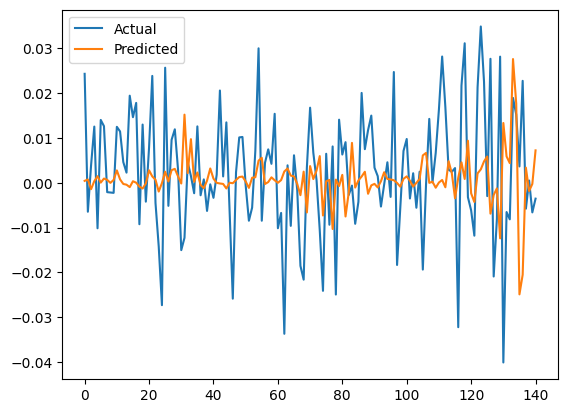

In [149]:
# plot predictions
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

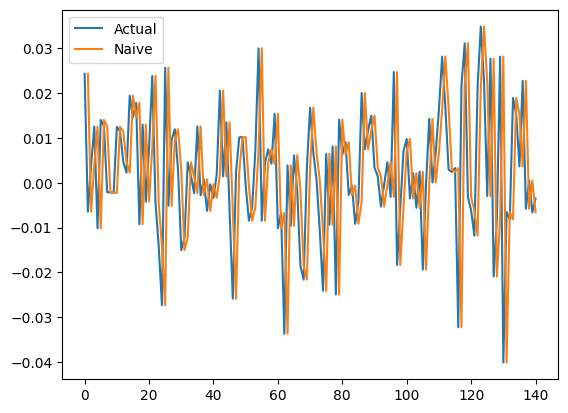

In [150]:
plt.plot(analysis['Actual_log_r'], label='Actual')
plt.plot(analysis['Actual_log_r'].shift(+1), label='Naive')
plt.legend()
plt.show()

In [154]:
print('LSTM:',mean_squared_error(analysis['Actual_simple_r'], analysis['Predicted_simple_r']))
print('NAIVE:',mean_squared_error(analysis['Actual_simple_r'][1:], analysis['Actual_simple_r'].shift(+1).dropna()))

LSTM: 0.00022800239893311242
NAIVE: 0.00037258782184163177
